In [2]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from google.cloud import bigquery
from google.oauth2 import service_account

In [3]:
# JSON key location
service_path = "C:/Users/vanes/OneDrive/Desktop/Work/MSBA/ADA/wedge_project/"
service_file = 'wedge-project-vw-key.json'  

# Give my credentials to Google
credentials = service_account.Credentials.from_service_account_file(service_path + service_file)

# GBQ project ID and dataset ID
proj_id = 'wedge-project-vw'

# And finally we establish our connection
client = bigquery.Client(credentials = credentials, project=proj_id)

I am having trouble with connecting to the UMT-MSBA project. Every time I try to connect, I receive an error stating that I don't have access even though I am using the `umt-msba-gg-key.json`. So I copied the view to my own project and queried it from there.

In [4]:
# We want all the rows from the view (thanks, John!)
query = '''
        SELECT *
        FROM `wedge-project-vw.dram_data.vw_customer_top_1k_items` 
        '''

# Execute the query
query_job = client.query(
    query,
    location="US",
)

# Convert the result to a dataframe
df = query_job.to_dataframe()

In [5]:
# pivot_table to deal with NA values
df_pivoted = df.pivot_table(index='customer_identifier', columns='clean_item_name', values='item_count', aggfunc=lambda x: 1 if any(x.notnull()) else 0, fill_value=0)

In [11]:
# Perform our PCA (black magic)
pca = PCA()
pca.fit(df_pivoted)

PCA()

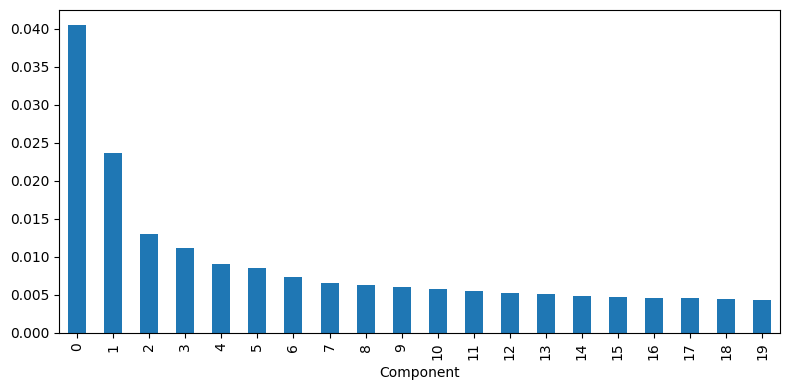

In [12]:
# Ripped off directly from the exercise
# exaplained_variance shows us how important each of the components is
explained_variance = pd.DataFrame(pca.explained_variance_ratio_)

# Make the plot - we only want to see the first 20 components
ax = explained_variance.head(20).plot.bar(legend=False, figsize=(8, 4))
ax.set_xlabel('Component')
plt.tight_layout()
plt.show()

In [ ]:
# loadings are the coefficients on the variables 
# We are interested in loadings that are large in absolute value
# We are also interested in the diversity of the loadings
loadings = pd.DataFrame(pca.components_, columns=df_pivoted.columns[0:])
loadings.transpose().sort_values(0)

In [14]:
# Also ripped off from the ecercise
# Write a function to show the components for each loading
def show_component(component,cutoff=0.05) : 
    
    # Sort the loadings by first swapping cols and rows
    pc_loading = loadings.transpose().iloc[:,component-1]

    # Sort the loadings by their values b/c we want highest abs value
    pc_loading = pc_loading.loc[pc_loading.abs() > cutoff].sort_values()
    max_pc = max(pc_loading.abs())
    colors = ['C0' if l > 0 else 'C1' for l in pc_loading]

    # Plot the loadings because it's easiest to visualize them
    pc_loading.plot.bar(color = colors)
    ax = plt.gca()
    plt.axhline(y=0,c="#888888")
    ax.set_ylim(-max_pc, max_pc)
    plt.tight_layout()
    plt.xticks(rotation=45, ha='right')
    plt.show()

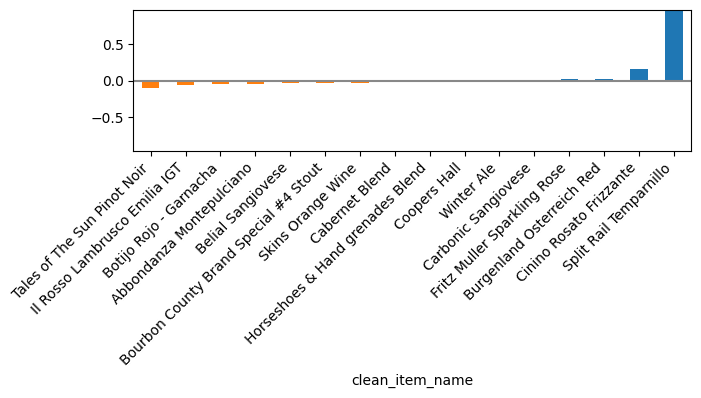

In [29]:
show_component(0,0.022)

This loading definitely has something to do with wine (go ahead and call me a Master Sommelier). I think this loading is related to the populariy of various wines. The Split Rail Temparnillo is not a very popular wine, but the ratio of unique customers to total units sold is fairly low.  

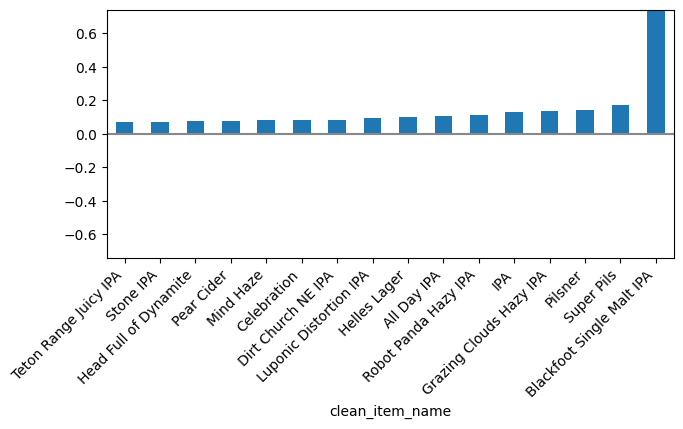

In [31]:
show_component(1,0.07)

Given that the item with the highest value in this loading is Blackfoot IPA, this loading is likely about the popularity of beers. Blackfoot is far and away the highest value here, which is consistent with its popularity. Super Pils is second, which is also a popular drink at the Dram shop. 

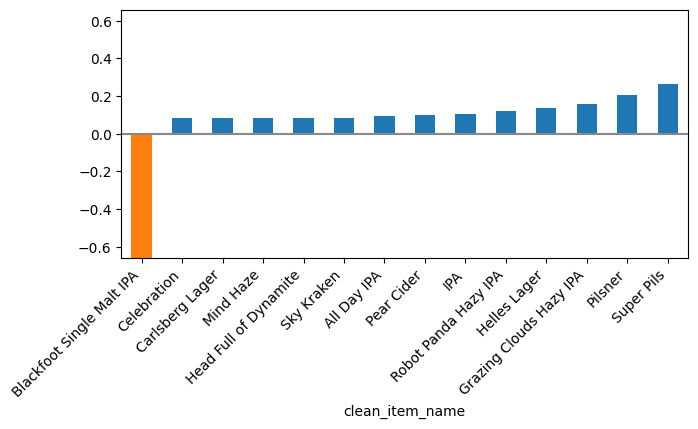

In [32]:
show_component(2,0.08)

This loading is interesting because Blackfoot IPA and Super Pils are at opposite ends of the spectrum. This might be about the total number of unique customers - Blackfoot IPA has far and away the highest number of unique customers, which makes sense that the loading would be so high, and each of the other beers have progressively fewer unique custoemrs. 

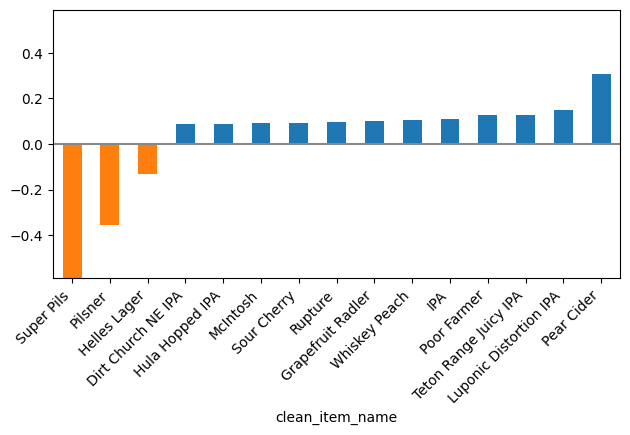

In [22]:
show_component(3,0.085)

This loading may be capturing people who prefer domestic beers or international beers. The Super Pils is from Belgium and the Pilsner may also international. The Pear Cider is either from Anthem, Ace Cider, or Finn River, all of which are domestic and West Coast cideries. This may indicate that people who like domestic breweries won't often go for international breweries.

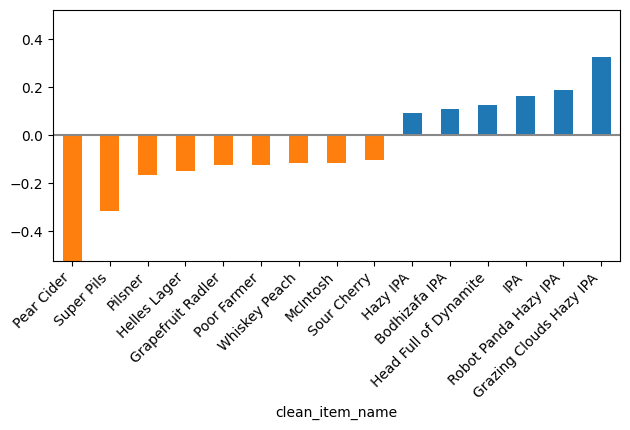

In [36]:
show_component(4,0.09)

The fifth loading seems to be capturing people who really like IPAs versus people who strongly prefer something milder or fruitier. Pear Cider, Super Pils, and Grazing Clouds Hazy IPA have the highest loadings, so it may be showing us that people who like hazy IPAs are not much of cider drinkers.

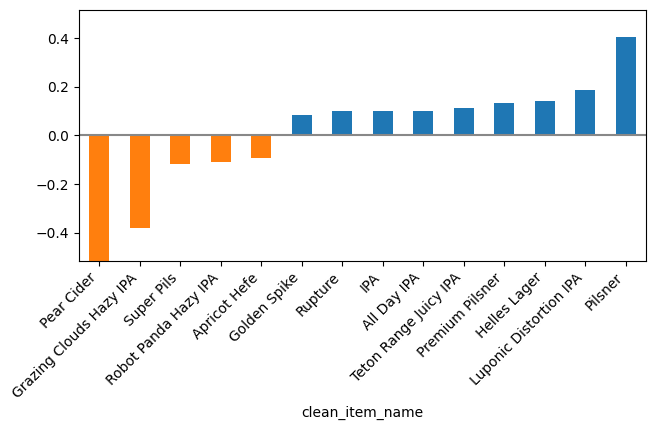

In [34]:
show_component(5,0.08)

The sixth loading appears to be capturing our ciderheads and pilsnerds again, along with Hazy IPA people. The relationship here may be about This time Pear Cider and Grazing Clouds Hazy IPA have the same directionality, which may indicate that this loading is capturing the type of a beer/cider. 